# Project 3 - Predict the Weekly Direction of Royal Bank (RY.TO)

## Feature Engineering

### A. Import Python Libraries

In [1]:
# Initial imports
import os
import csv
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import warnings
from pathlib import Path
import datetime as dt

#Subsequent imports
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import hvplot.pandas

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Enable the Matplotlib property to allow diagrams to display in Jupyter Notebook
%matplotlib inline

#### B. Import Data - Security/Stock Prices 

##### B.1. Yahoo Finance Data

In [2]:
# List the ticker symbols for the stocks of interest
lst_Stocks = ['BMO.TO', 'BNS.TO', 'CM.TO', 'NA.TO','RY.TO', 'TD.TO', 'ZEB.TO','ZWB.TO', 'XGB.TO', 'CL' ]
ticker = ['RY.TO']

# Determine the Date range for the desired data
start_date = '2014-01-01'
end_date = '2022-12-31'
df = yf.download(ticker, start= start_date, end= end_date)
df = df.sort_index()


[*********************100%***********************]  1 of 1 completed


#### C. Feature Engineering - X Variables

##### C.1. Add Feature X Varibles to a Dataframe

In [3]:
# Mid Range Variables
df['Mid_hl'] = (df['High'] + df['Low']) /2 
df['Mid_oc'] = (df['Open'] + df['Close']) /2 
df['Mid_hloc'] = (df['High'] + df['Low'] + df['Open'] + df['Close']) /4 

# Close in Range ==> Close at Low = 0, Close at High = 1
df['Close_in_range'] = 1 - ((df['High'] - df['Close']) / (df['High'] - df['Low']) )

# Daily/Weekly Returns - Average of Open and Close
df['Returns_1Day_Moc'] = df['Mid_oc'].pct_change()
df['Returns_5Day_Moc'] = df['Mid_oc'].pct_change(5)
df['Returns_30Day_Moc'] = df['Mid_oc'].pct_change(30)

# Daily/Weekly Returns - Average of High Low Open Close
df['Returns_1day_Mhloc'] = df['Mid_hloc'].pct_change()
df['Returns_5Day_Mhloc'] = df['Mid_hloc'].pct_change(5)
df['Returns_30Day_Mhloc'] = df['Mid_hloc'].pct_change(30)

# Daily/Weekly Standard Deviation - Average of Open and Close
df['Std_Dev_10Day_Moc'] = df['Mid_oc'].rolling(10).std()
df['Std_Dev_30Day_Moc'] = df['Mid_oc'].rolling(30).std()

# Daily/Weekly Standard Deviation - Average of Open and Close
df['Std_Dev_10Day_Mhloc'] = df['Mid_hloc'].rolling(10).std()
df['Std_Dev_30Day_Mhloc'] = df['Mid_hloc'].rolling(30).std()

# Simple Moving Average - 8 Day vs 20 Day
df['SMA_Returns_8Day_Mhloc'] = df['Returns_1Day_Moc'].rolling(8).std()
df['SMA_Returns_20Day_Mhloc'] = df['Returns_1Day_Moc'].rolling(20).std()
df['SMA_Delta_8_20Day_Mhloc'] = df['SMA_Returns_8Day_Mhloc'] - df['SMA_Returns_20Day_Mhloc']
df['SMA_Signal_8_20Day_Mhloc'] = np.where(df['SMA_Returns_8Day_Mhloc'] < 1, 0, 1) 


##### C.2. Display Feature X Varibles Dataframe

In [4]:
# Display
display(df.columns)
display(df.head(10))
display(df.tail(10))

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Mid_hl',
       'Mid_oc', 'Mid_hloc', 'Close_in_range', 'Returns_1Day_Moc',
       'Returns_5Day_Moc', 'Returns_30Day_Moc', 'Returns_1day_Mhloc',
       'Returns_5Day_Mhloc', 'Returns_30Day_Mhloc', 'Std_Dev_10Day_Moc',
       'Std_Dev_30Day_Moc', 'Std_Dev_10Day_Mhloc', 'Std_Dev_30Day_Mhloc',
       'SMA_Returns_8Day_Mhloc', 'SMA_Returns_20Day_Mhloc',
       'SMA_Delta_8_20Day_Mhloc', 'SMA_Signal_8_20Day_Mhloc'],
      dtype='object')

Open       High        Low      Close  \
Date                                                                    
2014-01-02 00:00:00-05:00  71.300003  71.639999  70.779999  71.589996   
2014-01-03 00:00:00-05:00  71.370003  71.459999  71.110001  71.389999   
2014-01-06 00:00:00-05:00  71.449997  71.500000  70.610001  70.699997   
2014-01-07 00:00:00-05:00  71.000000  71.440002  70.970001  70.970001   
2014-01-08 00:00:00-05:00  70.959999  71.180000  70.669998  71.000000   
2014-01-09 00:00:00-05:00  71.099998  71.290001  70.559998  71.120003   
2014-01-10 00:00:00-05:00  71.389999  71.419998  71.110001  71.180000   
2014-01-13 00:00:00-05:00  71.199997  71.500000  71.120003  71.209999   
2014-01-14 00:00:00-05:00  71.400002  71.459999  70.900002  70.900002   
2014-01-15 00:00:00-05:00  71.230003  71.250000  71.000000  71.059998   

                           Adj Close   Volume     Mid_hl     Mid_oc  \
Date                                                                  
2014-01-02 00:00:00-05:00  49.878250  1576100  71.209999  71.445000   
2014-01-03 00:00:00-05:00  49.738907  1243400  71.285000  71.380001   
2014-01-06 00:00:00-05:00  49.258179  2737700  71.055000  71.074997   
2014-01-07 00:00:00-05:00  49.446304  1374100  71.205002  70.985001   
2014-01-08 00:00:00-05:00  49.467190  1293700  70.924999  70.980000   
2014-01-09 00:00:00-05:00  49.550804  1824200  70.924999  71.110001   
2014-01-10 00:00:00-05:00  49.592598  1699500  71.264999  71.285000   
2014-01-13 00:00:00-05:00  49.613503  1922900  71.310001  71.204998   
2014-01-14 00:00:00-05:00  49.397526  2193800  71.180000  71.150002   
2014-01-15 00:00:00-05:00  49.508999  1574900  71.125000  71.145000   

                            Mid_hloc  Close_in_range  ...  Returns_5Day_Mhloc  \
Date                                                  ...                       
2014-01-02 00:00:00-05:00  71.327499        0.941857  ...                 NaN   
2014-01-03 00:00:00-05:00  71.332500        0.800000  ...                 NaN   
2014-01-06 00:00:00-05:00  71.064999        0.101120  ...                 NaN   
2014-01-07 00:00:00-05:00  71.095001        0.000000  ...                 NaN   
2014-01-08 00:00:00-05:00  70.952499        0.647060  ...                 NaN   
2014-01-09 00:00:00-05:00  71.017500        0.767127  ...           -0.004346   
2014-01-10 00:00:00-05:00  71.275000        0.225807  ...           -0.000806   
2014-01-13 00:00:00-05:00  71.257500        0.236834  ...            0.002709   
2014-01-14 00:00:00-05:00  71.165001        0.000000  ...            0.000985   
2014-01-15 00:00:00-05:00  71.135000        0.239990  ...            0.002572   

                           Returns_30Day_Mhloc  Std_Dev_10Day_Moc  \
Date                                                                
2014-01-02 00:00:00-05:00                  NaN                NaN   
2014-01-03 00:00:00-05:00                  NaN                NaN   
2014-01-06 00:00:00-05:00                  NaN                NaN   
2014-01-07 00:00:00-05:00                  NaN                NaN   
2014-01-08 00:00:00-05:00                  NaN                NaN   
2014-01-09 00:00:00-05:00                  NaN                NaN   
2014-01-10 00:00:00-05:00                  NaN                NaN   
2014-01-13 00:00:00-05:00                  NaN                NaN   
2014-01-14 00:00:00-05:00                  NaN                NaN   
2014-01-15 00:00:00-05:00                  NaN            0.15556   

                           Std_Dev_30Day_Moc  Std_Dev_10Day_Mhloc  \
Date                                                                
2014-01-02 00:00:00-05:00                NaN                  NaN   
2014-01-03 00:00:00-05:00                NaN                  NaN   
2014-01-06 00:00:00-05:00                NaN                  NaN   
2014-01-07 00:00:00-05:00                NaN                  NaN   
2014-01-08 00:00:00-05:00                NaN                  NaN   
2014-01-09 00:00:

Open        High         Low       Close  \
Date                                                                        
2022-12-15 00:00:00-05:00  128.539993  128.919998  127.349998  128.220001   
2022-12-16 00:00:00-05:00  127.199997  128.550003  127.190002  127.959999   
2022-12-19 00:00:00-05:00  128.000000  128.589996  126.400002  126.760002   
2022-12-20 00:00:00-05:00  127.540001  128.460007  127.080002  127.500000   
2022-12-21 00:00:00-05:00  128.139999  129.309998  128.089996  128.669998   
2022-12-22 00:00:00-05:00  128.000000  128.289993  126.349998  127.730003   
2022-12-23 00:00:00-05:00  127.720001  128.449997  127.260002  128.279999   
2022-12-28 00:00:00-05:00  127.559998  128.660004  127.300003  127.709999   
2022-12-29 00:00:00-05:00  128.149994  128.880005  127.820000  128.660004   
2022-12-30 00:00:00-05:00  128.119995  128.750000  126.680000  127.300003   

                            Adj Close   Volume      Mid_hl      Mid_oc  \
Date                                                                     
2022-12-15 00:00:00-05:00  126.967407  1972700  128.134998  128.379997   
2022-12-16 00:00:00-05:00  126.709946  6758500  127.870003  127.579998   
2022-12-19 00:00:00-05:00  125.521675  2569100  127.494999  127.380001   
2022-12-20 00:00:00-05:00  126.254440  3750500  127.770004  127.520000   
2022-12-21 00:00:00-05:00  127.413010  2183800  128.699997  128.404999   
2022-12-22 00:00:00-05:00  126.482201  2441100  127.319996  127.865002   
2022-12-23 00:00:00-05:00  127.026817  2134600  127.855000  128.000000   
2022-12-28 00:00:00-05:00  126.462387  3163800  127.980003  127.634998   
2022-12-29 00:00:00-05:00  127.403114  3256100  128.350002  128.404999   
2022-12-30 00:00:00-05:00  126.056396  3545800  127.715000  127.709999   

                             Mid_hloc  Close_in_range  ...  \
Date                                                   ...   
2022-12-15 00:00:00-05:00  128.257498        0.554142  ...   
2022-12-16 00:00:00-05:00  127.725000        0.566174  ...   
2022-12-19 00:00:00-05:00  127.437500        0.164384  ...   
2022-12-20 00:00:00-05:00  127.645002        0.304345  ...   
2022-12-21 00:00:00-05:00  128.552498        0.475411  ...   
2022-12-22 00:00:00-05:00  127.592499        0.711345  ...   
2022-12-23 00:00:00-05:00  127.927500        0.857144  ...   
2022-12-28 00:00:00-05:00  127.807501        0.301468  ...   
2022-12-29 00:00:00-05:00  128.377501        0.792453  ...   
2022-12-30 00:00:00-05:00  127.712500        0.299518  ...   

                           Returns_5Day_Mhloc  Returns_30Day_Mhloc  \
Date                                                                 
2022-12-15 00:00:00-05:00           -0.024973             0.024196   
2022-12-16 00:00:00-05:00           -0.026059             0.006323   
2022-12-19 00:00:00-05:00           -0.031685            -0.004356   
2022-12-20 00:00:00-05:00           -0.029592            -0.008082   
2022-12-21 00:00:00-05:00           -0.010335             0.002769   
2022-12-22 00:00:00-05:00           -0.005185            -0.020610   
2022-12-23 00:00:00-05:00            0.001585            -0.026557   
2022-12-28 00:00:00-05:00            0.002903            -0.029224   
2022-12-29 00:00:00-05:00            0.005739            -0.027591   
2022-12-30 00:00:00-05:00           -0.006534            -0.028581   

                           Std_Dev_10Day_Moc  Std_Dev_30Day_Moc  \
Date                                                              
2022-12-15 00:00:00-05:00           1.713111           2.238615   
2022-12-16 00:00:00-05:00           1.944264           2.183433   
2022-12-19 00:00:00-05:00           2.031338           2.226024   
2022-12-20 00:00:00-05:00           1.999690           2.283508   
2022-12-21 00:00:00-05:00           1.892899           2.271269   
2022-12-22 00:00:00-05:00           1.799863           2.372288   
2022-12-23 00:00:00-05:00           1.696145           2.471833   
2022-12-28 00:00:00-05:00     

##### C.3. Chart Feature X Varibles Dataframe - High vs. Low

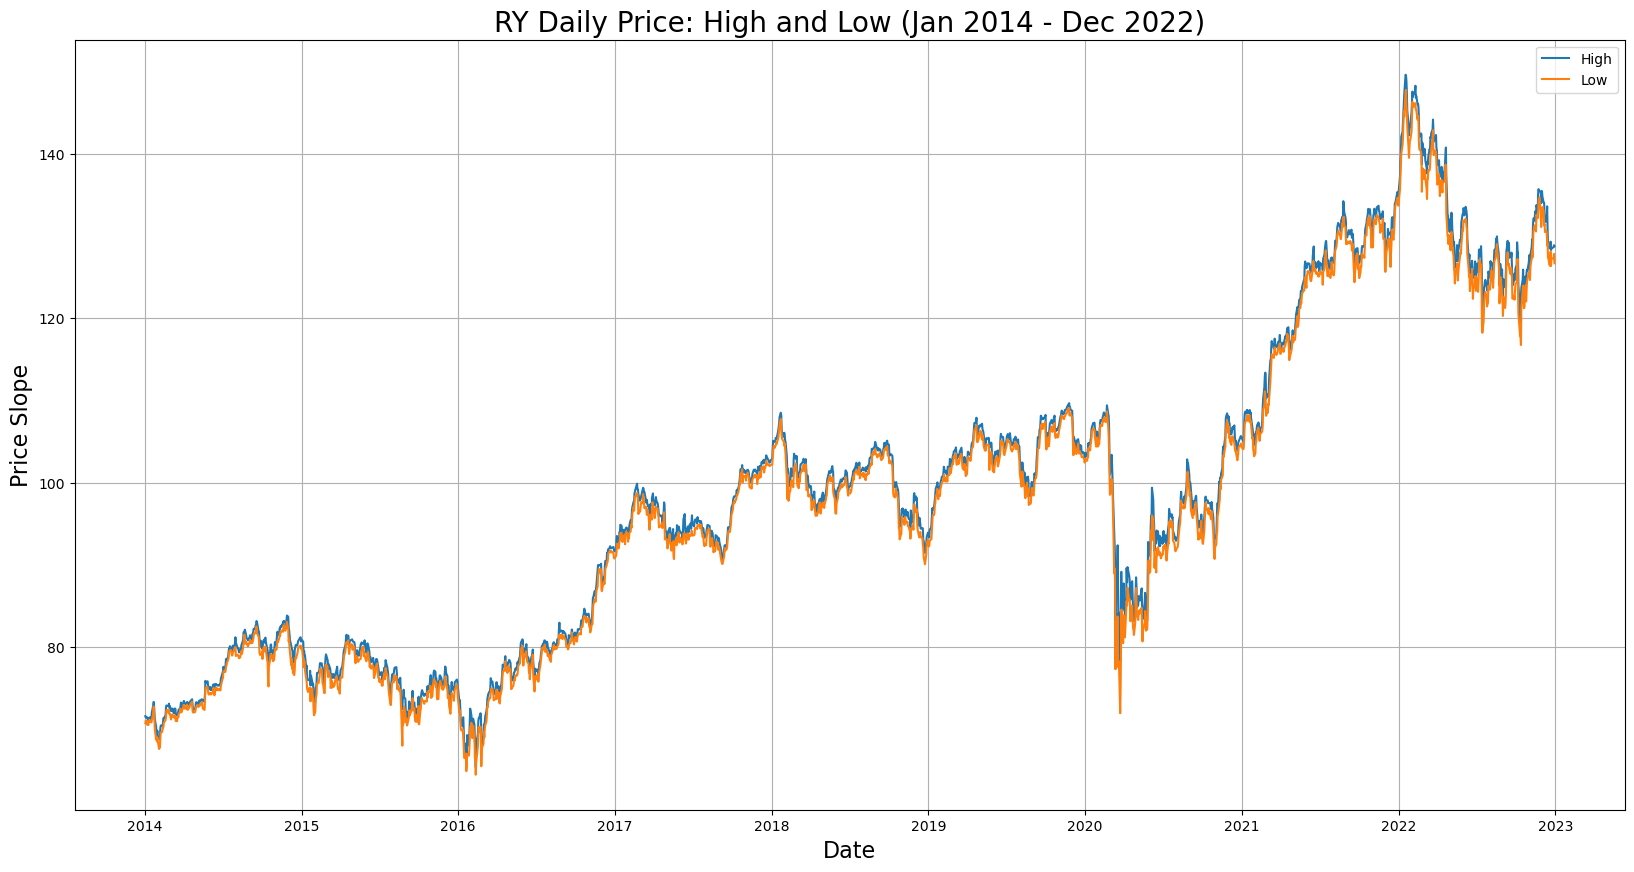

In [5]:
# Create a temporary data frame for charting
df_chart = df[['High','Low']]

# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

plt.plot(df_chart)
plt.title("RY Daily Price: High and Low (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(df_chart.columns)
plt.grid()

plt.show()


##### C.4. Chart Feature X Varibles Dataframe - Daily Retrns of Average Price High vs. Low vs. Open vs. Close

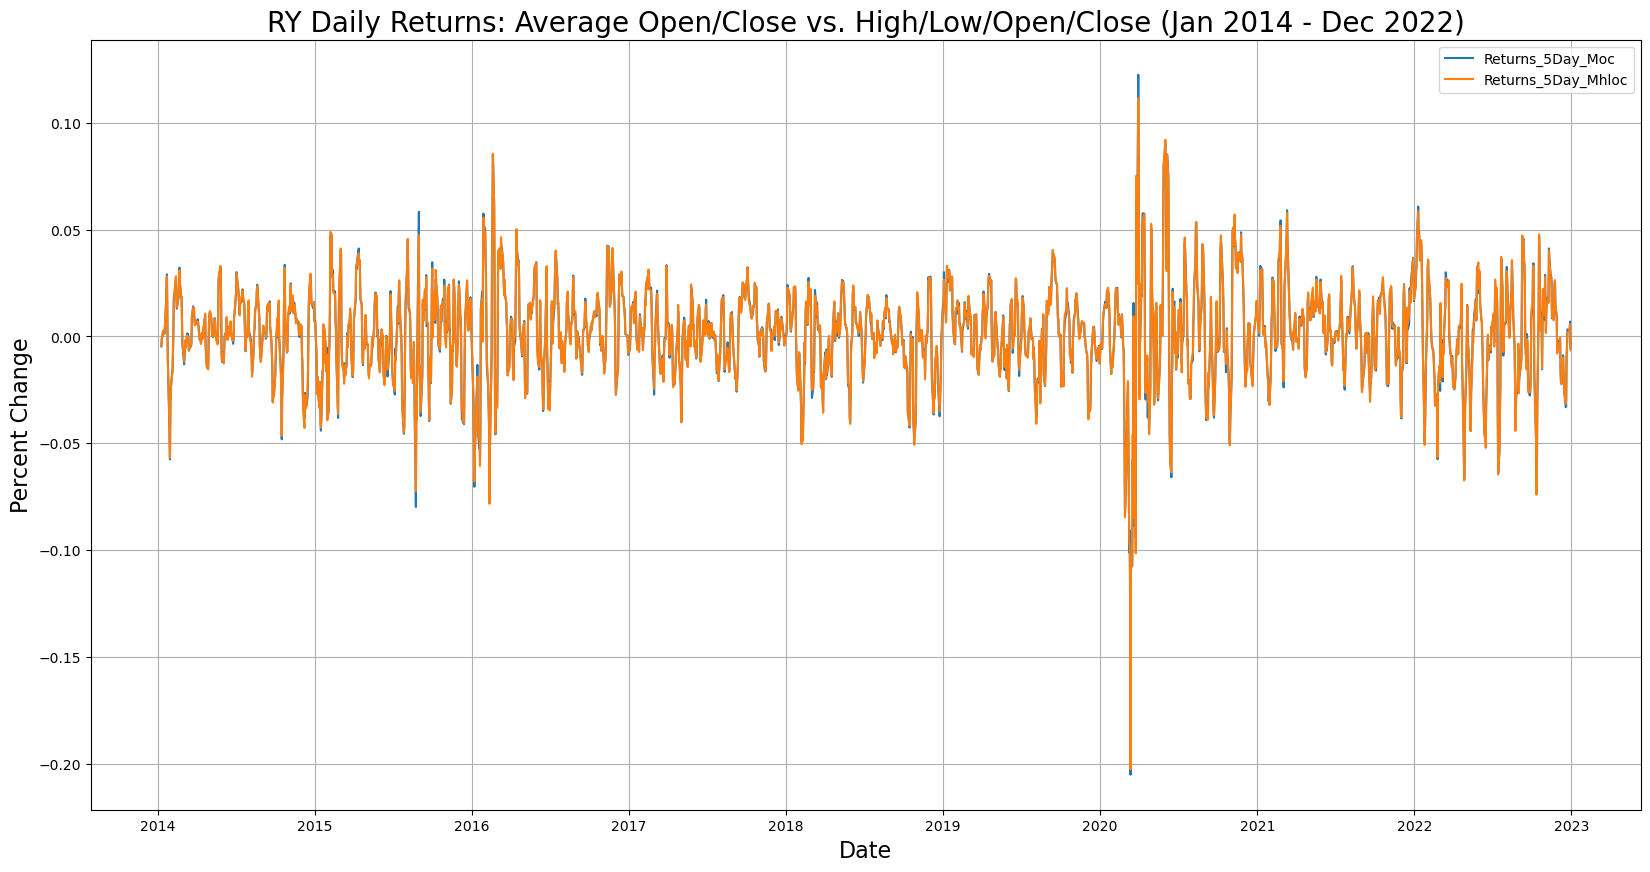

In [6]:
# Create a temporary data frame for charting
df_chart = df[['Returns_5Day_Moc','Returns_5Day_Mhloc']]

# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

plt.plot(df_chart)
plt.title("RY Daily Returns: Average Open/Close vs. High/Low/Open/Close (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Percent Change", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(df_chart.columns)
plt.grid()

plt.show()


##### C.5. Chart: Feature X Varibles Dataframe

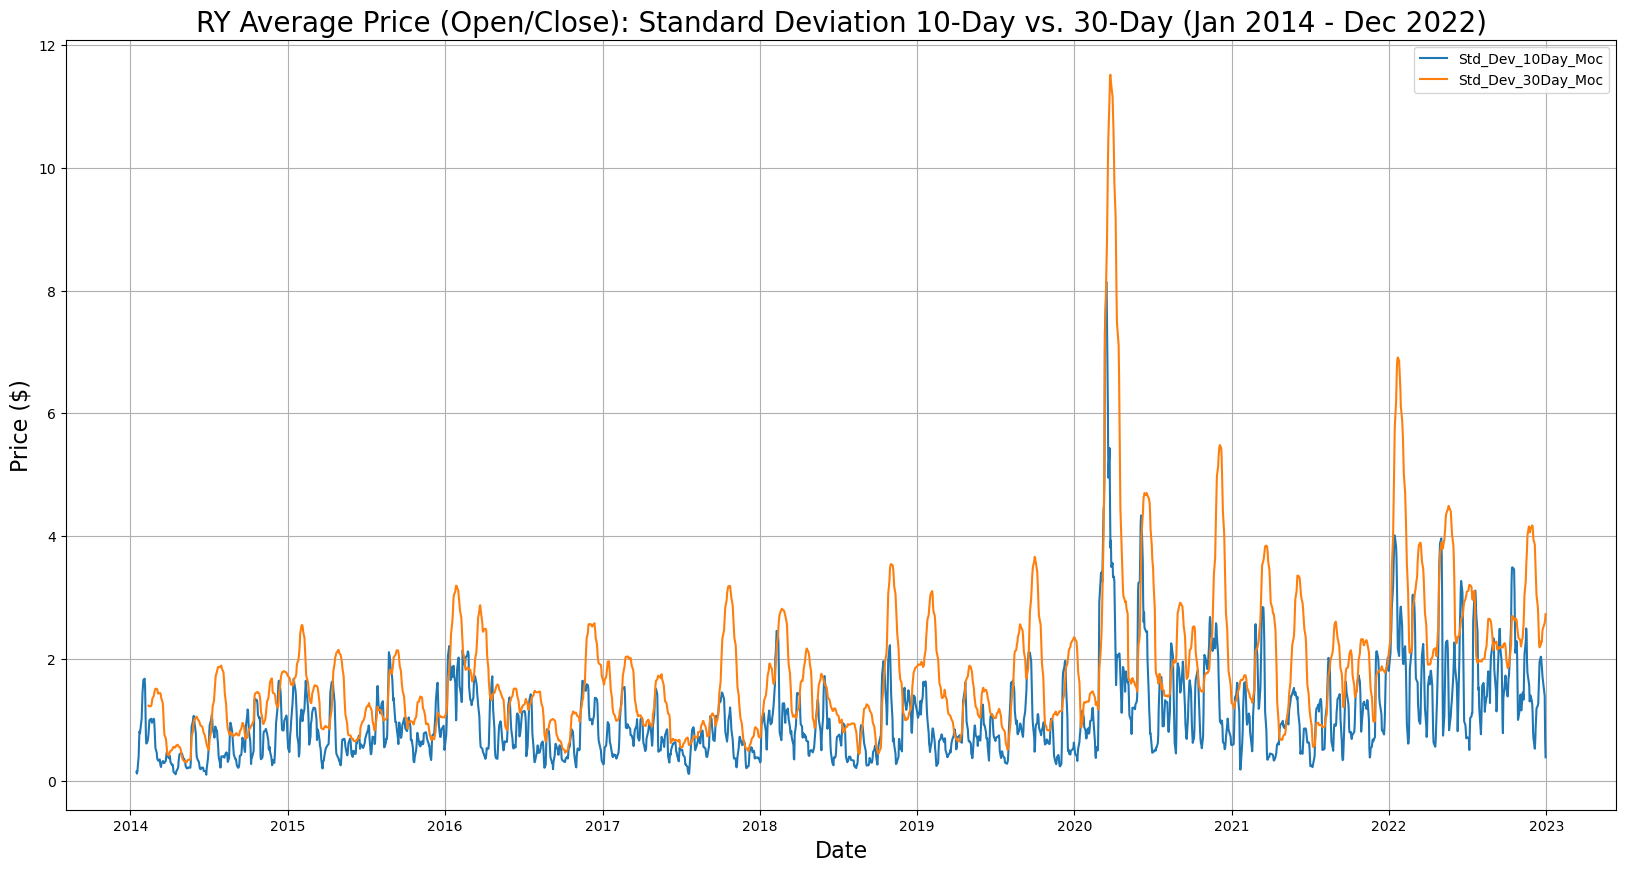

In [7]:
# Create a temporary data frame for charting
df_chart = df[['Std_Dev_10Day_Moc','Std_Dev_30Day_Moc']]

# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

plt.plot(df_chart)
plt.title("RY Average Price (Open/Close): Standard Deviation 10-Day vs. 30-Day (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price ($)", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(df_chart.columns)
plt.grid()

plt.show()


#### D. Feature Engineering - Target Y Variables

##### D.1. Add Target Y Varibles to a Dataframe

In [8]:
# Prepare df for trend determination
df = df.sort_index()
df = df.reset_index()
df

Date        Open        High         Low  \
0    2014-01-02 00:00:00-05:00   71.300003   71.639999   70.779999   
1    2014-01-03 00:00:00-05:00   71.370003   71.459999   71.110001   
2    2014-01-06 00:00:00-05:00   71.449997   71.500000   70.610001   
3    2014-01-07 00:00:00-05:00   71.000000   71.440002   70.970001   
4    2014-01-08 00:00:00-05:00   70.959999   71.180000   70.669998   
...                        ...         ...         ...         ...   
2253 2022-12-22 00:00:00-05:00  128.000000  128.289993  126.349998   
2254 2022-12-23 00:00:00-05:00  127.720001  128.449997  127.260002   
2255 2022-12-28 00:00:00-05:00  127.559998  128.660004  127.300003   
2256 2022-12-29 00:00:00-05:00  128.149994  128.880005  127.820000   
2257 2022-12-30 00:00:00-05:00  128.119995  128.750000  126.680000   

           Close   Adj Close   Volume      Mid_hl      Mid_oc    Mid_hloc  \
0      71.589996   49.878250  1576100   71.209999   71.445000   71.327499   
1      71.389999   49.738907  1243400   71.285000   71.380001   71.332500   
2      70.699997   49.258179  2737700   71.055000   71.074997   71.064999   
3      70.970001   49.446304  1374100   71.205002   70.985001   71.095001   
4      71.000000   49.467190  1293700   70.924999   70.980000   70.952499   
...          ...         ...      ...         ...         ...         ...   
2253  127.730003  126.482201  2441100  127.319996  127.865002  127.592499   
2254  128.279999  127.026817  2134600  127.855000  128.000000  127.927500   
2255  127.709999  126.462387  3163800  127.980003  127.634998  127.807501   
2256  128.660004  127.403114  3256100  128.350002  128.404999  128.377501   
2257  127.300003  126.056396  3545800  127.715000  127.709999  127.712500   

      ...  Returns_5Day_Mhloc  Returns_30Day_Mhloc  Std_Dev_10Day_Moc  \
0     ...                 NaN                  NaN                NaN   
1     ...                 NaN                  NaN                NaN   
2     ...                 NaN                  NaN                NaN   
3     ...                 NaN                  NaN                NaN   
4     ...                 NaN                  NaN                NaN   
...   ...                 ...                  ...                ...   
2253  ...           -0.005185            -0.020610           1.799863   
2254  ...            0.001585            -0.026557           1.696145   
2255  ...            0.002903            -0.029224           1.387690   
2256  ...            0.005739            -0.027591           0.705252   
2257  ...           -0.006534            -0.028581           0.390691   

      Std_Dev_30Day_Moc  Std_Dev_10Day_Mhloc  Std_Dev_30Day_Mhloc  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
...                 ...                  ...                  ...   
2253           2.372288             1.734330             2.352026   
2254           2.471833             1.615645             2.453807   
2255           2.580417             1.303273             2.551936   
2256           2.640458             0.721363             2.613162   
2257           2.726106             0.369688             2.698204   

      SMA_Returns_8Day_Mhloc  SMA_Returns_20Day_Mhloc  \
0                        NaN                      NaN   
1                        NaN                      NaN   
2                        NaN                      NaN   
3                        NaN                      NaN   
4                        NaN                      NaN   
...                      ...                      ...   
2253                0.007210                 0.005732   
2254                0.007227                 0.005762   
2255                0.005333             

##### D.2. Regression to determine the trend

In [9]:
# Calculate the 10-day forward looking slope of daily price benchmarks 
# Slope = coefecient from sklearn regression model
# Price Benchmarks = high, low, open, close

# Initialize X variable 1-10 
X = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]])

# Initialize results dataframe
df_target_y = pd.DataFrame(columns = ['index', 'high_slope','high_intercept', 'mid_hl_slope', 'mid_hl_intercept', 'mid_oc_slope', 'mid_oc_intercept', 'low_slope', 'low_intercept', 'trend_10day'])

# Calculate from 1st to last less 10 days
for i in range(len(df) - 10):
    
    # Initialize y variables
    trend = 10
    y_High = np.array([])
    y_Mid_hl = np.array([])
    y_Mid_oc = np.array([])
    y_Low = np.array([])
    count = 0
    
    # Calculate y variables and add them to the array
    for j in range (i , i + 10):
        y_High = np.insert(y_High, len(y_High), df['High'].iloc[[j]])
        y_Mid_hl = np.insert(y_Mid_hl, len(y_Mid_hl), (df['High'].iloc[[j]] + df['Low'].iloc[[j]])/2)
        y_Mid_oc = np.insert(y_Mid_oc, len(y_Mid_oc), (df['Open'].iloc[[j]] + df['Close'].iloc[[j]])/2)
        y_Low = np.insert(y_Low, len(y_Low), df['Low'].iloc[[j]])
        count += 1
    
    # Reshape the y array for the regression model   
    y_High = y_High.reshape(-1,1)
    y_Mid_hl = y_Mid_hl.reshape(-1,1)
    y_Mid_oc = y_Mid_oc.reshape(-1,1)
    y_Low = y_Low.reshape(-1,1)
    
    # Regression models
    reg_High = LinearRegression().fit(X, y_High)
    reg_Mid_hl = LinearRegression().fit(X, y_Mid_hl)
    reg_Mid_oc = LinearRegression().fit(X, y_Mid_oc)
    reg_Low = LinearRegression().fit(X, y_Low)
    
    # Determine trend 
    # 0 - Down = 3 negative coefecients or 2 negative and the sum of all 4 is negative
    # 1 - Up   = 3 positive coefecients or 2 positive and the sum of all 4 is positive
    if (reg_High.coef_ > 0 and reg_Mid_hl.coef_ > 0 and reg_Mid_oc.coef_ > 0):
        trend = 1
    elif (reg_High.coef_ > 0 and reg_Mid_oc.coef_ > 0 and reg_Low.coef_ > 0): 
        trend = 1
    elif (reg_Mid_hl.coef_ > 0 and reg_Mid_oc.coef_ > 0 and reg_Low.coef_ > 0):
        trend = 1
    elif (reg_High.coef_ < 0 and reg_Mid_hl.coef_ < 0 and reg_Mid_oc.coef_ < 0):
        trend = 0
    elif (reg_High.coef_ < 0 and reg_Mid_oc.coef_ < 0 and reg_Low.coef_ < 0): 
        trend = 0
    elif (reg_Mid_hl.coef_ < 0 and reg_Mid_oc.coef_ < 0 and reg_Low.coef_ < 0):
        trend = 0
    elif (reg_High.coef_  + reg_Mid_hl.coef_ + reg_Mid_oc.coef_ + reg_Low.coef_ > 0):
        trend = 1    
    else: 
        trend =0
    
    # Populate result dataframe
    df_temp = pd.DataFrame({"index":i,  "high_slope": reg_High.coef_[0],     "high_intercept": reg_High.intercept_[0], 
                                        "mid_hl_slope": reg_Mid_hl.coef_[0], "mid_hl_intercept": reg_Mid_hl.intercept_[0],
                                        "mid_oc_slope": reg_Mid_oc.coef_[0], "mid_oc_intercept": reg_Mid_oc.intercept_[0], 
                                        "low_slope": reg_Low.coef_[0],       "low_intercept": reg_Low.intercept_[0],
                                        "trend_10day": trend})
    
    df_target_y = pd.concat([df_target_y,df_temp], axis = "rows")
    
    #print(f" row {i} xxx High: {reg_High.coef_} xxx Mid HiLo: {reg_Mid_hl.coef_} xxx Mid OpCl: {reg_Mid_oc.coef_} xxx Low: {reg_Low.coef_} xxx {trend}")
    #print('========================')



### D.3. Display Regression Variables

In [10]:
# Display result Dataframe
df_target_y = df_target_y.set_index(['index'])
display(df_target_y.columns)
display(df_target_y)


C:\Users\jersk\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


Index(['high_slope', 'high_intercept', 'mid_hl_slope', 'mid_hl_intercept',
       'mid_oc_slope', 'mid_oc_intercept', 'low_slope', 'low_intercept',
       'trend_10day'],
      dtype='object')

high_slope  high_intercept  mid_hl_slope  mid_hl_intercept  \
index                                                               
0       -0.020970       71.529333     -0.000273         71.150000   
1       -0.008849       71.434667      0.002273         71.127000   
2        0.031758       71.269334      0.036273         70.970001   
3        0.112727       70.960001      0.093576         70.785334   
4        0.199939       70.671333      0.184333         70.473667   
...           ...             ...           ...               ...   
2243    -0.526728      133.382005     -0.488515        132.220335   
2244    -0.518122      132.922673     -0.482152        131.773336   
2245    -0.497516      132.483337     -0.411667        131.049667   
2246    -0.378607      131.453338     -0.276303        129.955667   
2247    -0.123455      129.578001     -0.095394        128.673666   

       mid_oc_slope  mid_oc_intercept  low_slope  low_intercept trend_10day  
index                                                                        
0         -0.015939         71.263666   0.020424      70.770666           0  
1          0.002758         71.135333   0.013394      70.819334           1  
2          0.037121         70.958332   0.040788      70.670668           1  
3          0.096606         70.759667   0.074424      70.610667           1  
4          0.166152         70.572666   0.168727      70.276000           1  
...             ...               ...        ...            ...         ...  
2243      -0.545636        132.536001  -0.450303     131.058666           0  
2244      -0.496061        131.885336  -0.446182     130.623999           0  
2245      -0.431637        131.224003  -0.325818     129.615997           0  
2246      -0.305243        130.118334  -0.173999     128.457996           0  
2247      -0.079424        128.531333  -0.067333     127.769331           0  

[2248 rows x 9 columns]

##### D.4. Concatinate Regression Regression Target Y Variables to Feature X Variable Dataframe

In [11]:
df = pd.concat([df, df_target_y], axis= 1)
df = df.set_index(['Date'])
display(df.head(11))
display(df.tail(11))


Open       High        Low      Close  \
Date                                                                    
2014-01-02 00:00:00-05:00  71.300003  71.639999  70.779999  71.589996   
2014-01-03 00:00:00-05:00  71.370003  71.459999  71.110001  71.389999   
2014-01-06 00:00:00-05:00  71.449997  71.500000  70.610001  70.699997   
2014-01-07 00:00:00-05:00  71.000000  71.440002  70.970001  70.970001   
2014-01-08 00:00:00-05:00  70.959999  71.180000  70.669998  71.000000   
2014-01-09 00:00:00-05:00  71.099998  71.290001  70.559998  71.120003   
2014-01-10 00:00:00-05:00  71.389999  71.419998  71.110001  71.180000   
2014-01-13 00:00:00-05:00  71.199997  71.500000  71.120003  71.209999   
2014-01-14 00:00:00-05:00  71.400002  71.459999  70.900002  70.900002   
2014-01-15 00:00:00-05:00  71.230003  71.250000  71.000000  71.059998   
2014-01-16 00:00:00-05:00  71.019997  71.360001  70.879997  71.360001   

                           Adj Close   Volume     Mid_hl     Mid_oc  \
Date                                                                  
2014-01-02 00:00:00-05:00  49.878250  1576100  71.209999  71.445000   
2014-01-03 00:00:00-05:00  49.738907  1243400  71.285000  71.380001   
2014-01-06 00:00:00-05:00  49.258179  2737700  71.055000  71.074997   
2014-01-07 00:00:00-05:00  49.446304  1374100  71.205002  70.985001   
2014-01-08 00:00:00-05:00  49.467190  1293700  70.924999  70.980000   
2014-01-09 00:00:00-05:00  49.550804  1824200  70.924999  71.110001   
2014-01-10 00:00:00-05:00  49.592598  1699500  71.264999  71.285000   
2014-01-13 00:00:00-05:00  49.613503  1922900  71.310001  71.204998   
2014-01-14 00:00:00-05:00  49.397526  2193800  71.180000  71.150002   
2014-01-15 00:00:00-05:00  49.508999  1574900  71.125000  71.145000   
2014-01-16 00:00:00-05:00  49.718010  2022100  71.119999  71.189999   

                            Mid_hloc  Close_in_range  ...  \
Date                                                  ...   
2014-01-02 00:00:00-05:00  71.327499        0.941857  ...   
2014-01-03 00:00:00-05:00  71.332500        0.800000  ...   
2014-01-06 00:00:00-05:00  71.064999        0.101120  ...   
2014-01-07 00:00:00-05:00  71.095001        0.000000  ...   
2014-01-08 00:00:00-05:00  70.952499        0.647060  ...   
2014-01-09 00:00:00-05:00  71.017500        0.767127  ...   
2014-01-10 00:00:00-05:00  71.275000        0.225807  ...   
2014-01-13 00:00:00-05:00  71.257500        0.236834  ...   
2014-01-14 00:00:00-05:00  71.165001        0.000000  ...   
2014-01-15 00:00:00-05:00  71.135000        0.239990  ...   
2014-01-16 00:00:00-05:00  71.154999        1.000000  ...   

                           SMA_Signal_8_20Day_Mhloc  high_slope  \
Date                                                              
2014-01-02 00:00:00-05:00                         1   -0.020970   
2014-01-03 00:00:00-05:00                         1   -0.008849   
2014-01-06 00:00:00-05:00                         1    0.031758   
2014-01-07 00:00:00-05:00                         1    0.112727   
2014-01-08 00:00:00-05:00                         1    0.199939   
2014-01-09 00:00:00-05:00                         1    0.246667   
2014-01-10 00:00:00-05:00                         1    0.206242   
2014-01-13 00:00:00-05:00                         1    0.119939   
2014-01-14 00:00:00-05:00                         0   -0.007333   
2014-01-15 00:00:00-05:00                         0   -0.158303   
2014-01-16 00:00:00-05:00                         0   -0.324606   

                           high_intercept  mid_hl_slope  mid_hl_intercept  \
Date                                                                        
2014-01-02 00:00:00-05:00       71.529333     -0.000273         71.150000   
2014-01-03 00:00:00-05:00       71.434667      0.002273         71.127000   
2014-01-06 00:00:00-05:00       71.269334      0.036273         70.970001   
2014-01-07 00:00:00-05:00       70.960001      0.093576         70.785334   
2014-01-08 00:00:00-05:00     

Open        High         Low       Close  \
Date                                                                        
2022-12-14 00:00:00-05:00  130.130005  130.880005  129.149994  129.419998   
2022-12-15 00:00:00-05:00  128.539993  128.919998  127.349998  128.220001   
2022-12-16 00:00:00-05:00  127.199997  128.550003  127.190002  127.959999   
2022-12-19 00:00:00-05:00  128.000000  128.589996  126.400002  126.760002   
2022-12-20 00:00:00-05:00  127.540001  128.460007  127.080002  127.500000   
2022-12-21 00:00:00-05:00  128.139999  129.309998  128.089996  128.669998   
2022-12-22 00:00:00-05:00  128.000000  128.289993  126.349998  127.730003   
2022-12-23 00:00:00-05:00  127.720001  128.449997  127.260002  128.279999   
2022-12-28 00:00:00-05:00  127.559998  128.660004  127.300003  127.709999   
2022-12-29 00:00:00-05:00  128.149994  128.880005  127.820000  128.660004   
2022-12-30 00:00:00-05:00  128.119995  128.750000  126.680000  127.300003   

                            Adj Close   Volume      Mid_hl      Mid_oc  \
Date                                                                     
2022-12-14 00:00:00-05:00  128.155685  1800800  130.014999  129.775002   
2022-12-15 00:00:00-05:00  126.967407  1972700  128.134998  128.379997   
2022-12-16 00:00:00-05:00  126.709946  6758500  127.870003  127.579998   
2022-12-19 00:00:00-05:00  125.521675  2569100  127.494999  127.380001   
2022-12-20 00:00:00-05:00  126.254440  3750500  127.770004  127.520000   
2022-12-21 00:00:00-05:00  127.413010  2183800  128.699997  128.404999   
2022-12-22 00:00:00-05:00  126.482201  2441100  127.319996  127.865002   
2022-12-23 00:00:00-05:00  127.026817  2134600  127.855000  128.000000   
2022-12-28 00:00:00-05:00  126.462387  3163800  127.980003  127.634998   
2022-12-29 00:00:00-05:00  127.403114  3256100  128.350002  128.404999   
2022-12-30 00:00:00-05:00  126.056396  3545800  127.715000  127.709999   

                             Mid_hloc  Close_in_range  ...  \
Date                                                   ...   
2022-12-14 00:00:00-05:00  129.895000        0.156071  ...   
2022-12-15 00:00:00-05:00  128.257498        0.554142  ...   
2022-12-16 00:00:00-05:00  127.725000        0.566174  ...   
2022-12-19 00:00:00-05:00  127.437500        0.164384  ...   
2022-12-20 00:00:00-05:00  127.645002        0.304345  ...   
2022-12-21 00:00:00-05:00  128.552498        0.475411  ...   
2022-12-22 00:00:00-05:00  127.592499        0.711345  ...   
2022-12-23 00:00:00-05:00  127.927500        0.857144  ...   
2022-12-28 00:00:00-05:00  127.807501        0.301468  ...   
2022-12-29 00:00:00-05:00  128.377501        0.792453  ...   
2022-12-30 00:00:00-05:00  127.712500        0.299518  ...   

                           SMA_Signal_8_20Day_Mhloc  high_slope  \
Date                                                              
2022-12-14 00:00:00-05:00                         0   -0.123455   
2022-12-15 00:00:00-05:00                         0         NaN   
2022-12-16 00:00:00-05:00                         0         NaN   
2022-12-19 00:00:00-05:00                         0         NaN   
2022-12-20 00:00:00-05:00                         0         NaN   
2022-12-21 00:00:00-05:00                         0         NaN   
2022-12-22 00:00:00-05:00                         0         NaN   
2022-12-23 00:00:00-05:00                         0         NaN   
2022-12-28 00:00:00-05:00                         0         NaN   
2022-12-29 00:00:00-05:00                         0         NaN   
2022-12-30 00:00:00-05:00                         0         NaN   

                           high_intercept  mid_hl_slope  mid_hl_intercept  \
Date                                                                        
2022-12-14 00:00:00-05:00      129.578001     -0.095394        128.673666   
2022-12-15 00:00:00-05:00             NaN           NaN               NaN   
2022-12-16 00:00:00-05:00             NaN           NaN               NaN   
2022

##### D.5. Chart: Target Y Varibles

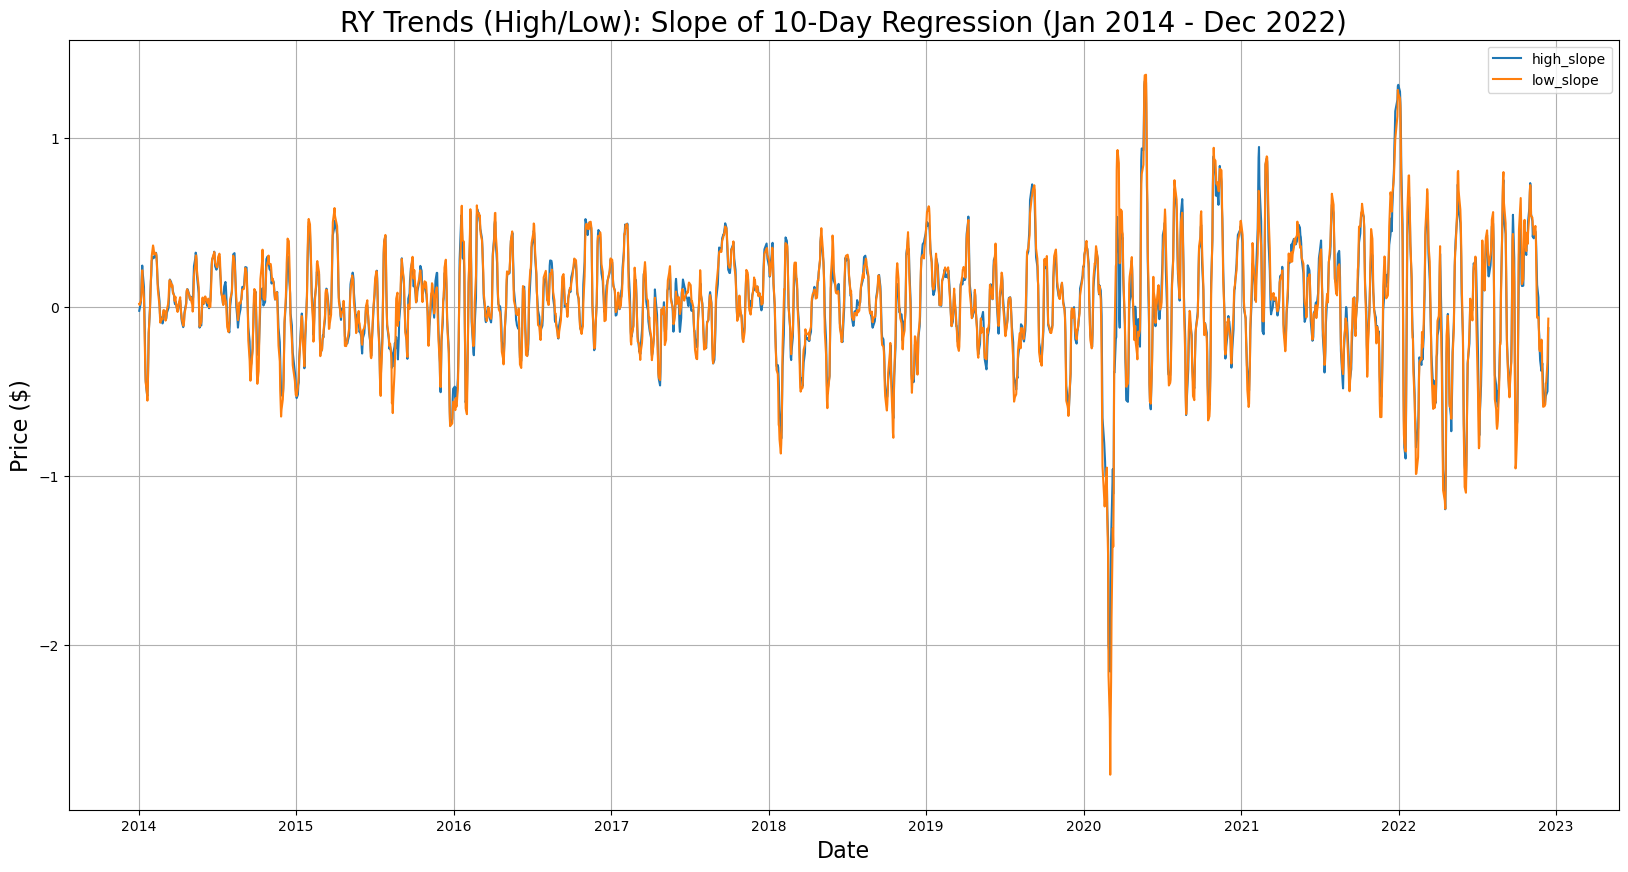

In [12]:
# Create a temporary data frame for charting
df_chart = df[['high_slope','low_slope']]

# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

plt.plot(df_chart)
plt.title("RY Trends (High/Low): Slope of 10-Day Regression (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price ($)", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend(df_chart.columns)
plt.grid()

plt.show()


### E. Output Dataframe to CSV file

In [13]:
df.to_csv('../Data/Feature_Engineering.RY.csv', encoding='utf-8')